In [21]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import openslide
from skimage.color import rgb2hsv
import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax

In [2]:
hdf5_path = '/home/irene/Downloads/luadlusc.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()

<KeysViewHDF5 ['test_img', 'test_label', 'train_img', 'train_label', 'val_img', 'val_label']>

In [3]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [4]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
            self.labels = h5py.File(self.file_path, 'r')[self.set + "_label"]
            
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)
            label = self.labels[index].astype('float32')
            
            
        return (image,label)

    def __len__(self):
        return self.dataset_len

In [5]:
from torch.utils.data import Dataset,DataLoader

train_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="train"), batch_size=8,shuffle=True,drop_last=False)
val_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="val"), batch_size=8,shuffle=True,drop_last=False)
test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("densenet121", pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, out_dim)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()



def train_valid_model (net,loaders,max_epochs = 20):
    best_acc = 0.0 
    for epoch in range (max_epochs):
        for phase in ['train','val']:
            iterator = iter(loaders[phase])
            total_step = len(loaders[phase])
            print('Phase {}'.format(phase))
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            predictions_all = []
            label_all = []
            probs_all = []
            for step in range(total_step-1): #iterate each batch
                images,labels = next(iterator) # CUDA computation
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.long()
                optimizer.zero_grad()
                
                output = net(images)
                loss = criterion(output,labels)
                
                probs = torch.nn.functional.softmax(output, dim=1) # probabilities
                
                running_loss +=loss.item()
                _, preds = torch.max(output.data,1)
                
                running_correct += (preds == labels).sum().item()
                
                if len(predictions_all) == 0:
                    predictions_all = preds.detach().cpu().numpy()
                    label_all = labels.detach().cpu().numpy()
                    probs_all = probs.detach().cpu().numpy()
                else:
                    predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                    probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))
                    label_all = np.vstack((label_all, labels.detach().cpu().numpy()))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
                    
            phase_loss = running_loss / len(loaders[phase])
            phase_acc = running_correct/len(label_all.flatten())
            if phase == 'val':
                y_true = label_all.flatten()
                y_pred = predictions_all.flatten()
                print("validating...")
                print(len(y_true))
                print(len(y_pred))
                print(metrics.classification_report(y_true, y_pred, digits=3))
            if phase == 'val' and phase_acc > best_acc:
                
                best_acc = phase_acc
                import copy 
                
                best_model_state_dict = copy.deepcopy(net.state_dict())
                torch.save(best_model_state_dict,'densenet121best_model.pth')
                
            print('PHASE {} Loss: {:.4f} Acc: {:.4f}'.format(phase, phase_loss, phase_acc))
    net.load_state_dict(best_model_state_dict)
    
    return net 
            
       
print(device)  

cuda


In [14]:
def test_best_model (net, test_loader, a_device = None):
    iterator = iter(test_loader)
    total_step = len(test_loader)
    
    print(total_step)
    net.eval()
    
    with torch.no_grad():
        running_loss = 0
        running_corrects = 0
        
        total_0,total_1 = 0,0
        hit_0 = 0
        hit_1 = 0
        label_all = []
        probs_all = []
        predictions_all = []
        for step in range(total_step-1):
            images,labels = next(iterator)
            images.to(a_device)
            labels.to(a_device)
            total_0 += labels.tolist().count(0)
            total_1 += labels.tolist().count(1)
            print(labels.shape)
            images = images.to(a_device)
            labels = labels.to(device=a_device, dtype=torch.int64)
            labels = labels.long()
            
            output = net(images)
            loss = criterion(output,labels)
            
            probs = torch.nn.functional.softmax(output, dim=1)

            running_loss +=loss.item()
            _, preds = torch.max(output.data,1)
            
            equals = preds == labels.view(*preds.shape)
            if(len(label_all) ==0):
                predictions_all = preds.detach().cpu().numpy()
                label_all = labels.detach().cpu().numpy()
                probs_all = probs.detach().cpu().numpy()
            else:
                predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
                probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))

            all_hits = equals.view(equals.shape[0]).tolist() 
            all_corrects = labels[all_hits]
            
            hit_0 += all_corrects.tolist().count(0)
            hit_1 += all_corrects.tolist().count(1)
 
        
            running_corrects += (preds == labels).sum().item()
        print(len(label_all.flatten()))
        label_all = label_all.flatten()
        predictions_all = predictions_all.flatten()
        phase_loss = running_loss / len(test_loader)
        phase_acc = running_corrects/len(label_all.flatten())
        print('Test Loss: {:.4f} Acc: {:.4f}'.format(phase_loss, phase_acc))
        
        print(hit_0, ' / ',total_0)
        print(hit_1, ' / ',total_1)
                
            
    return label_all, probs_all, predictions_all #add this later
                
        #y_test --> label, y_score --> probs all 

In [12]:
epochs = 10
loaders = dict({'train': train_loader, 'val': val_loader})
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    bestmodel = train_valid_model (model,loaders)
    

Epoch 1
-----------------------
Phase train
PHASE train Loss: 0.4677 Acc: 0.7766
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.870     0.911     0.890      4528
           1      0.923     0.886     0.904      5400

    accuracy                          0.898      9928
   macro avg      0.897     0.899     0.897      9928
weighted avg      0.899     0.898     0.898      9928

PHASE val Loss: 0.3405 Acc: 0.8978
Phase train
PHASE train Loss: 0.2813 Acc: 0.8778
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.835     0.926     0.878      4529
           1      0.932     0.846     0.887      5399

    accuracy                          0.883      9928
   macro avg      0.884     0.886     0.883      9928
weighted avg      0.888     0.883     0.883      9928

PHASE val Loss: 3.6522 Acc: 0.8830
Phase train
PHASE train Loss: 0.1983 Acc: 0.9176
Phase val
validating...
9928


PHASE train Loss: 0.0194 Acc: 0.9934
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.972     0.978     0.975      4528
           1      0.981     0.976     0.979      5400

    accuracy                          0.977      9928
   macro avg      0.977     0.977     0.977      9928
weighted avg      0.977     0.977     0.977      9928

PHASE val Loss: 0.2290 Acc: 0.9769
Epoch 2
-----------------------
Phase train
PHASE train Loss: 0.0229 Acc: 0.9923
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.981     0.987     0.984      4529
           1      0.989     0.984     0.986      5399

    accuracy                          0.985      9928
   macro avg      0.985     0.985     0.985      9928
weighted avg      0.985     0.985     0.985      9928

PHASE val Loss: 0.0727 Acc: 0.9851
Phase train
PHASE train Loss: 0.0205 Acc: 0.9931
Phase val
validating...
9928
9928
       

PHASE train Loss: 0.0084 Acc: 0.9970
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.996     0.930     0.962      4528
           1      0.944     0.997     0.970      5400

    accuracy                          0.966      9928
   macro avg      0.970     0.963     0.966      9928
weighted avg      0.968     0.966     0.966      9928

PHASE val Loss: 2.3572 Acc: 0.9661
Phase train
PHASE train Loss: 0.0074 Acc: 0.9978
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.935     0.963      4529
           1      0.948     0.995     0.971      5399

    accuracy                          0.968      9928
   macro avg      0.971     0.965     0.967      9928
weighted avg      0.969     0.968     0.967      9928

PHASE val Loss: 2.2201 Acc: 0.9676
Epoch 3
-----------------------
Phase train
PHASE train Loss: 0.0159 Acc: 0.9948
Phase val
validating...
9928
9928
       

PHASE train Loss: 0.0092 Acc: 0.9968
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.976     0.984      4529
           1      0.980     0.994     0.987      5399

    accuracy                          0.986      9928
   macro avg      0.986     0.985     0.986      9928
weighted avg      0.986     0.986     0.986      9928

PHASE val Loss: 0.2371 Acc: 0.9858
Phase train
PHASE train Loss: 0.0058 Acc: 0.9980
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.996     0.951     0.973      4529
           1      0.960     0.997     0.978      5399

    accuracy                          0.976      9928
   macro avg      0.978     0.974     0.976      9928
weighted avg      0.977     0.976     0.976      9928

PHASE val Loss: 0.7762 Acc: 0.9760
Phase train
PHASE train Loss: 0.0101 Acc: 0.9963
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0080 Acc: 0.9971
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.982     0.961     0.972      4529
           1      0.968     0.985     0.977      5399

    accuracy                          0.974      9928
   macro avg      0.975     0.973     0.974      9928
weighted avg      0.975     0.974     0.974      9928

PHASE val Loss: 1.0493 Acc: 0.9744
Phase train
PHASE train Loss: 0.0084 Acc: 0.9975
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.990     0.979     0.984      4528
           1      0.983     0.991     0.987      5400

    accuracy                          0.986      9928
   macro avg      0.986     0.985     0.986      9928
weighted avg      0.986     0.986     0.986      9928

PHASE val Loss: 0.1245 Acc: 0.9859
Phase train
PHASE train Loss: 0.0068 Acc: 0.9974
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0068 Acc: 0.9979
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.973     0.987     0.979      4528
           1      0.989     0.977     0.983      5400

    accuracy                          0.981      9928
   macro avg      0.981     0.982     0.981      9928
weighted avg      0.981     0.981     0.981      9928

PHASE val Loss: 1.2588 Acc: 0.9812
Phase train
PHASE train Loss: 0.0058 Acc: 0.9983
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.913     0.998     0.954      4529
           1      0.998     0.921     0.958      5399

    accuracy                          0.956      9928
   macro avg      0.956     0.959     0.956      9928
weighted avg      0.959     0.956     0.956      9928

PHASE val Loss: 6.4818 Acc: 0.9558
Phase train
PHASE train Loss: 0.0046 Acc: 0.9988
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0051 Acc: 0.9984
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.976     0.993     0.984      4528
           1      0.994     0.980     0.987      5400

    accuracy                          0.986      9928
   macro avg      0.985     0.986     0.986      9928
weighted avg      0.986     0.986     0.986      9928

PHASE val Loss: 0.3363 Acc: 0.9856
Phase train
PHASE train Loss: 0.0076 Acc: 0.9977
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.943     0.994     0.968      4528
           1      0.994     0.950     0.971      5400

    accuracy                          0.970      9928
   macro avg      0.969     0.972     0.970      9928
weighted avg      0.971     0.970     0.970      9928

PHASE val Loss: 2.5051 Acc: 0.9697
Phase train
PHASE train Loss: 0.0051 Acc: 0.9987
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0069 Acc: 0.9978
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.986     0.977     0.981      4528
           1      0.981     0.988     0.984      5400

    accuracy                          0.983      9928
   macro avg      0.983     0.982     0.983      9928
weighted avg      0.983     0.983     0.983      9928

PHASE val Loss: 0.1294 Acc: 0.9829
Phase train
PHASE train Loss: 0.0055 Acc: 0.9984
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.990     0.978     0.984      4529
           1      0.981     0.992     0.987      5399

    accuracy                          0.985      9928
   macro avg      0.986     0.985     0.985      9928
weighted avg      0.986     0.985     0.985      9928

PHASE val Loss: 0.0746 Acc: 0.9855
Phase train
PHASE train Loss: 0.0029 Acc: 0.9992
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0057 Acc: 0.9982
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.975     0.984      4529
           1      0.980     0.995     0.987      5399

    accuracy                          0.986      9928
   macro avg      0.987     0.985     0.986      9928
weighted avg      0.986     0.986     0.986      9928

PHASE val Loss: 0.0650 Acc: 0.9859
Phase train
PHASE train Loss: 0.0045 Acc: 0.9984
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.994     0.976     0.985      4528
           1      0.980     0.995     0.988      5400

    accuracy                          0.986      9928
   macro avg      0.987     0.986     0.986      9928
weighted avg      0.987     0.986     0.986      9928

PHASE val Loss: 0.1079 Acc: 0.9864
Phase train
PHASE train Loss: 0.0048 Acc: 0.9985
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0012 Acc: 0.9999
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.986     0.990     0.988      4529
           1      0.991     0.988     0.990      5399

    accuracy                          0.989      9928
   macro avg      0.989     0.989     0.989      9928
weighted avg      0.989     0.989     0.989      9928

PHASE val Loss: 0.0668 Acc: 0.9888
Phase train
PHASE train Loss: 0.0016 Acc: 0.9996
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.994     0.978     0.986      4528
           1      0.982     0.995     0.988      5400

    accuracy                          0.987      9928
   macro avg      0.988     0.987     0.987      9928
weighted avg      0.987     0.987     0.987      9928

PHASE val Loss: 0.0909 Acc: 0.9873
Phase train
PHASE train Loss: 0.0017 Acc: 0.9996
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0048 Acc: 0.9985
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.987     0.966     0.976      4529
           1      0.972     0.989     0.981      5399

    accuracy                          0.979      9928
   macro avg      0.980     0.978     0.979      9928
weighted avg      0.979     0.979     0.979      9928

PHASE val Loss: 0.3767 Acc: 0.9787
Phase train
PHASE train Loss: 0.0047 Acc: 0.9986
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.959     0.998     0.978      4528
           1      0.998     0.964     0.981      5400

    accuracy                          0.979      9928
   macro avg      0.978     0.981     0.979      9928
weighted avg      0.980     0.979     0.979      9928

PHASE val Loss: 1.2714 Acc: 0.9794
Phase train
PHASE train Loss: 0.0043 Acc: 0.9986
Phase val
validating...
9928
9928
              precision    recall  f1-s

In [8]:
model_path = 'densenet121best_model.pth'

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("densenet121", pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, out_dim)

In [10]:
my_dict = torch.load(model_path)

In [11]:
model.load_state_dict(my_dict)

<All keys matched successfully>

In [12]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [15]:
y_test, y_prob, y_pred= test_best_model (model, test_loader, a_device = device)


1242
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
tor

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

In [17]:
fpr = dict()
tpr = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [18]:
roc_auc = roc_auc_score(y_test, y_prob[:,1])
print('AUC: %.3f' % roc_auc)

AUC: 0.998


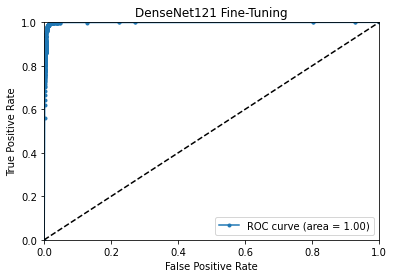

In [19]:
# ROC Curves and AUC
plt.plot(fpr,tpr ,marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet121 Fine-Tuning')
plt.legend(loc="lower right")
plt.savefig('DenseNet121 Fine-Tuning.png')

In [22]:
accuracy = accuracy_score(y_test,y_pred,normalize = True)
print(accuracy)

0.9889202256244963


In [23]:
f1 = f1_score(y_test, y_pred)
print(f1)

0.9898841272760713
